# Projection of the risk free curve and recalibration inside OSEM

The purpose of this workbook is to showcase the calibration methodology inside OSEM. The key to the calibration is the Smith Wilson algorithm commonly used in insurance. This algorithm allows a continious approximation of arbitrary maturities based on a subset of available maturities.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [30]:
from ImportData import import_SWEiopa
from CurvesClass import Curves

## Importing external files

The parameters and the current risk free curve are provided as input:

 - Parameters.csv; Parameters related to the run 
 - EIOPA_param_file.csv; Assumed yield curve at modelling date and relevant maturities
 - EIOPA_curves_file.csv; Parameters related to the EIOPA time 0 calibration

### Read the necessary input files

In [31]:
paramfile = pd.read_csv("Input\Parameters.csv", index_col="Parameter")

The location of the two EIOPA files are:

In [32]:
selected_param_file = paramfile["Value"].loc["EIOPA_param_file"]
selected_curves_file = paramfile["Value"].loc["EIOPA_curves_file"]

In [33]:
selected_param_file

'Input/Param_no_VA.csv'

In [34]:
selected_curves_file

'Input/Curves_no_VA.csv'

The risk free curve belongs to the following country:

In [35]:
country = paramfile["Value"].loc["country"]

In [36]:
country

'Slovenia'

Import all necessary parameters:

In [37]:
[maturities_country, curve_country, extra_param, Qb] = import_SWEiopa(selected_param_file, selected_curves_file, country)

## The curve class

The curve class object contains all the data necessary to run the model.

In [38]:
# ultimate forward rate
ufr = extra_param["UFR"]/100
# Numeric precision of the optimisation
precision = float(paramfile["Value"].loc["Precision"])

# Targeted distance between the extrapolated curve and the ultimate forward rate at the convergence point
tau = float(paramfile["Value"].loc["Tau"])# 1 basis point

modelling_date = paramfile.loc["Modelling_Date"]

In [39]:
curves = Curves(ufr, precision, tau, modelling_date, country)

SetObservedTermStructure sets the liquid maturities and the coresponding yields to the m_obs and r_obs property of the Curves class. 

In [40]:
curves.SetObservedTermStructure(maturity_vec=curve_country.index.tolist(), yield_vec=curve_country.values)

### Calculate 1 year forward rates

The forward rates will be used to calculate forward spot curves

In [41]:
curves.CalcFwdRates()

In [42]:
display(curves.fwd_rates)

,Forward
0,NaN
1,1.031582
2,1.027909
3,1.026170
4,1.026146
...,...
145,1.034191
146,1.034211
147,1.034231
148,1.034251


### Forward yield curve

The forward yield curve can be calculated by using the 1-year forward rates from the suitable moment onwards. The formula used is:

$$
y_i(t-i) = \prod_i^t\big(1+fw_{EIOPA}(t)\big)^{\frac{1}{t-i}}
$$

### Calculate term structure calibration for the modelling date

In [43]:
ProjYear = 0
# Number of projection years
N = int(paramfile.loc["n_proj_years"][0])

In [44]:
curves.ProjectForwardRate(N)

In [45]:
display(curves.r_obs)

,Yield,Yield year1,Yield year2,Yield year3,Yield year4,Yield year5,Yield year6,Yield year7,Yield year8,Yield year9,...,Yield year40,Yield year41,Yield year42,Yield year43,Yield year44,Yield year45,Yield year46,Yield year47,Yield year48,Yield year49
0,0.03472,0.031582,0.027909,0.026170,0.026146,0.026663,0.027041,0.027560,0.028290,0.028950,...,0.033653,0.033492,0.033733,0.033531,0.034204,0.033982,0.033731,0.033931,0.034131,0.034332
1,0.03315,0.029745,0.027039,0.026158,0.026404,0.026852,0.027301,0.027925,0.028620,0.028010,...,0.033573,0.033612,0.033632,0.033867,0.034093,0.033856,0.033831,0.034031,0.034232,0.034176
2,0.03140,0.028552,0.026741,0.026326,0.026617,0.027088,0.027631,0.028267,0.028104,0.029452,...,0.033626,0.033585,0.033823,0.033906,0.033972,0.033881,0.033931,0.034131,0.034161,0.034184
3,0.03009,0.027951,0.026722,0.026505,0.026853,0.027389,0.027960,0.027968,0.029161,0.029882,...,0.033602,0.033740,0.033862,0.033862,0.033962,0.033944,0.034031,0.034104,0.034171,0.034233
4,0.02930,0.027693,0.026786,0.026716,0.027140,0.027701,0.027782,0.028841,0.029563,0.029543,...,0.033723,0.033788,0.033836,0.033876,0.033996,0.034021,0.034029,0.034123,0.034213,0.034299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.03274,0.032739,0.032757,0.032801,0.032856,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,0.03275,0.032749,0.032768,0.032811,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,0.03276,0.032760,0.032778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,0.03277,0.032770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate the alpha parameter

Calibration of the alpha parameter for the base curve using the bisection algorithm.

In [46]:
alphaoptimized = [curves.BisectionAlpha(0.05, 0.5, curves.m_obs["Maturity"], curves.r_obs["Yield"], curves.ufr, curves.tau, curves.precision, 1000)]
if "Yield year" in curves.alpha.columns:
    curves.alpha["Yield year"] = alphaoptimized
else:
    curves.alpha = curves.alpha.join(pd.Series(data=None, index=None, name="Yield year",dtype='float64'))
    curves.alpha["Yield year"] = alphaoptimized

### Calibrate first calibration vector b

In [47]:
bCalibrated = curves.SWCalibrate(curves.r_obs["Yield"], curves.m_obs["Maturity"], curves.ufr, curves.alpha["Yield year"][0])
bCalibrated = np.append(bCalibrated,np.repeat(np.nan, ProjYear))

In [48]:
if "Yield year" in curves.b.columns:
    curves.b["Yield year"] = bCalibrated
else:
    curves.b = curves.b.join(pd.Series(data= None,index=None, name="Yield year",dtype='float64'))
    curves.b["Yield year"] = bCalibrated

## Calibrate every yield curve

### Parameters that stay the same

# Repeat for all

In [49]:
for iYear in range(1,N):
    ProjYear = iYear
    NameOfYear = "Yield year"+str(ProjYear)
    r_Obs = np.transpose(np.array(curves.r_obs[NameOfYear]))[:-ProjYear] # Obtain the yield curve
    M_Obs = np.transpose(np.array(range(1,r_Obs.size+1)))
    alphaoptimized = [curves.BisectionAlpha(0.05, 0.5, M_Obs, r_Obs, curves.ufr, curves.tau, curves.precision, 1000)]
    if NameOfYear in curves.alpha.columns:
        curves.alpha[NameOfYear] = alphaoptimized
    else:
        curves.alpha = curves.alpha.join(pd.Series(data=None, index=None, name=NameOfYear,dtype='float64'))
        curves.alpha[NameOfYear] = alphaoptimized
    bCalibrated = curves.SWCalibrate(r_Obs, M_Obs, curves.ufr, curves.alpha[NameOfYear][0])
    bCalibrated = np.append(bCalibrated,np.repeat(np.nan,ProjYear))
    if NameOfYear in curves.b.columns:
        curves.b[NameOfYear] = bCalibrated
    else:
        curves.b = curves.b.join(pd.Series(data= None,index=None, name=NameOfYear,dtype='float64'))
        curves.b[NameOfYear] = bCalibrated
    r_Obs_Est = curves.SWExtrapolate(M_Obs, M_Obs, curves.b[NameOfYear][:-(ProjYear)], curves.ufr, curves.alpha[NameOfYear][0])

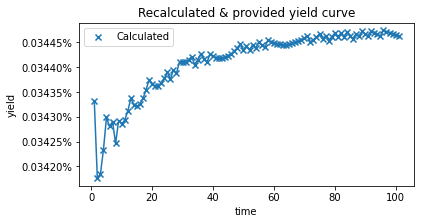

In [50]:
fig, ax1 = plt.subplots(1,1)
ax1.scatter(M_Obs, r_Obs, label="Calculated",marker="x")
ax1.plot(M_Obs, r_Obs_Est)
ax1.set_ylabel("yield")
ax1.set_title('Recalculated & provided yield curve')
ax1.set_xlabel("time")
ax1.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(6)
fig.set_figheight(3)
plt.show()

### Saving calibrated results

In [51]:
#curves.b.to_csv("Intermediate/b.csv")

In [52]:
#curves.alpha.to_csv("Intermediate/alpha.csv")

In [53]:
curves.r_obs

,Yield,Yield year1,Yield year2,Yield year3,Yield year4,Yield year5,Yield year6,Yield year7,Yield year8,Yield year9,...,Yield year40,Yield year41,Yield year42,Yield year43,Yield year44,Yield year45,Yield year46,Yield year47,Yield year48,Yield year49
0,0.03472,0.031582,0.027909,0.026170,0.026146,0.026663,0.027041,0.027560,0.028290,0.028950,...,0.033653,0.033492,0.033733,0.033531,0.034204,0.033982,0.033731,0.033931,0.034131,0.034332
1,0.03315,0.029745,0.027039,0.026158,0.026404,0.026852,0.027301,0.027925,0.028620,0.028010,...,0.033573,0.033612,0.033632,0.033867,0.034093,0.033856,0.033831,0.034031,0.034232,0.034176
2,0.03140,0.028552,0.026741,0.026326,0.026617,0.027088,0.027631,0.028267,0.028104,0.029452,...,0.033626,0.033585,0.033823,0.033906,0.033972,0.033881,0.033931,0.034131,0.034161,0.034184
3,0.03009,0.027951,0.026722,0.026505,0.026853,0.027389,0.027960,0.027968,0.029161,0.029882,...,0.033602,0.033740,0.033862,0.033862,0.033962,0.033944,0.034031,0.034104,0.034171,0.034233
4,0.02930,0.027693,0.026786,0.026716,0.027140,0.027701,0.027782,0.028841,0.029563,0.029543,...,0.033723,0.033788,0.033836,0.033876,0.033996,0.034021,0.034029,0.034123,0.034213,0.034299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.03274,0.032739,0.032757,0.032801,0.032856,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,0.03275,0.032749,0.032768,0.032811,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,0.03276,0.032760,0.032778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,0.03277,0.032770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
#curves.m_obs.to_csv("Intermediate/M_Obs.csv")

In [55]:
#curves.fwd_rates.to_csv("Intermediate/FwdRates.csv")

In [56]:
#Qb.to_csv("Intermediate/Qb_0.csv") 